# Prediction of countries' GDP — Midterm 

### This notebook was produced to predict the countries GDP . using the previous data .

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

%matplotlib inline
print('Libraries loaded')

Libraries loaded


In [2]:
# Configuration
DATA_PATH = DATA_PATH = r'C:\Users\csvr\Downloads\Mid term\data\world_bank_data_2025.csv'  
TARGET_COL = 'GDP (Current USD)' 
RANDOM_STATE = 42

# Load data
df = pd.read_csv(DATA_PATH)
print('Data loaded. Shape:', df.shape)
df.head()

Data loaded. Shape: (3472, 16)


,country_name,country_id,year,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),Government Revenue (% of GDP),Tax Revenue (% of GDP),Gross National Income (USD),Public Debt (% of GDP)
0,Aruba,aw,2010,2.078141,2.453597e+09,24093.140151,NaN,11.666131,-1.223407,-2.733457,-18.752537,NaN,NaN,NaN,2.313385e+09,NaN
1,Aruba,aw,2011,4.316297,2.637859e+09,25712.384302,NaN,4.801974,4.005674,3.369237,-9.877656,NaN,NaN,NaN,2.391841e+09,NaN
2,Aruba,aw,2012,0.627472,2.615208e+09,25119.665545,NaN,8.200875,0.184033,-1.040800,3.473451,NaN,NaN,NaN,2.499118e+09,NaN
3,Aruba,aw,2013,-2.372065,2.727850e+09,25813.576727,NaN,10.709709,-1.995948,6.431483,-11.813206,NaN,NaN,NaN,2.563517e+09,NaN
4,Aruba,aw,2014,0.421441,2.790850e+09,26129.839062,NaN,3.213869,3.958897,-1.586575,-4.658577,NaN,NaN,NaN,2.688102e+09,NaN


In [3]:
# Quick data checks
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum().sort_values(ascending=False).head(20))
print('\nNumerical summary:\n', df.describe().T.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country_name                     3472 non-null   object 
 1   country_id                       3472 non-null   object 
 2   year                             3472 non-null   int64  
 3   Inflation (CPI %)                2694 non-null   float64
 4   GDP (Current USD)                2933 non-null   float64
 5   GDP per Capita (Current USD)     2938 non-null   float64
 6   Unemployment Rate (%)            2795 non-null   float64
 7   Interest Rate (Real, %)          1735 non-null   float64
 8   Inflation (GDP Deflator, %)      2904 non-null   float64
 9   GDP Growth (% Annual)            2912 non-null   float64
 10  Current Account Balance (% GDP)  2563 non-null   float64
 11  Government Expense (% of GDP)    1820 non-null   float64
 12  Government Revenue (

In [4]:
# Ensure target exists and simple cleaning
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataframe columns: {df.columns.tolist()}")

# Drop rows where target is missing
n_before = df.shape[0]
df = df.dropna(subset=[TARGET_COL])
print(f'Dropped {n_before - df.shape[0]} rows with missing target.')


possible_ids = ['Country Name','Country','Country_Code','Year']
for c in possible_ids:
    if c in df.columns:
        print('Dropping identifier column:', c)
        df = df.drop(columns=[c])

print('Shape after basic cleaning:', df.shape)

Dropped 539 rows with missing target.
Shape after basic cleaning: (2933, 16)


In [5]:
# Separate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float)

# Identify numerical and categorical
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numerical columns:', num_cols)
print('Categorical columns:', cat_cols)

Numerical columns: ['year', 'Inflation (CPI %)', 'GDP per Capita (Current USD)', 'Unemployment Rate (%)', 'Interest Rate (Real, %)', 'Inflation (GDP Deflator, %)', 'GDP Growth (% Annual)', 'Current Account Balance (% GDP)', 'Government Expense (% of GDP)', 'Government Revenue (% of GDP)', 'Tax Revenue (% of GDP)', 'Gross National Income (USD)', 'Public Debt (% of GDP)']
Categorical columns: ['country_name', 'country_id']


In [6]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (2346, 15) Test shape: (587, 15)


In [7]:
# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

print('Preprocessor defined')

Preprocessor defined


In [8]:
# Baseline: Linear Regression pipeline
lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr) ** 0.5
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression — MAE: {mae_lr:.3f}, RMSE: {rmse_lr:.3f}, R2: {r2_lr:.3f}')

Linear Regression — MAE: 4214028701.740, RMSE: 16597770175.954, R2: 1.000


In [9]:
# Random Forest with RandomizedSearchCV
rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', rf)
])

rs = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=12, cv=3, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)

print('Best params:', rs.best_params_)
print('Best CV MAE:', -rs.best_score_)

best_model = rs.best_estimator_

y_pred_rf = best_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest — MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20}
Best CV MAE: 19535092179.09627
Random Forest — MAE: 23930146935.428, RMSE: 247574177178.173, R2: 0.987


In [10]:
# Evaluation summary
results = pd.DataFrame({
    'model': ['LinearRegression','RandomForest'],
    'MAE': [mae_lr, mae_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R2': [r2_lr, r2_rf]
})

results

,model,MAE,RMSE,R2
0,LinearRegression,4.214029e+09,1.659777e+10,0.999942
1,RandomForest,2.393015e+10,2.475742e+11,0.987129


Residuals mean: 9584040697.643362


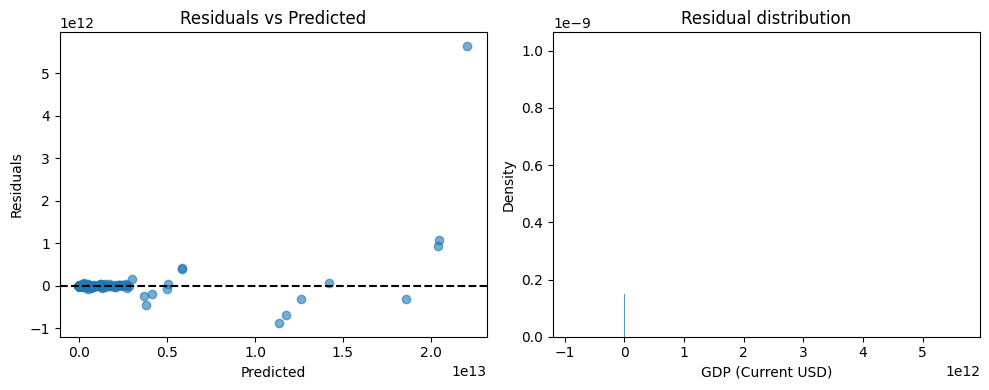

In [11]:
# Residual diagnostics for best model
residuals = y_test - y_pred_rf
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_pred_rf, residuals, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(1,2,2)
sns.histplot(residuals, stat='density')
plt.title('Residual distribution')
plt.tight_layout()

print('Residuals mean:', residuals.mean())

In [12]:
# Feature importance (approximate, after preprocessing)
try:
    # Get feature names after preprocessing
    num_features = num_cols
    cat_features = []
    if len(cat_cols) > 0:
        ohe = best_model.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
        cat_features = list(ohe.get_feature_names_out(cat_cols))
    all_features = list(num_features) + cat_features
    importances = best_model.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=all_features).sort_values(ascending=False).head(20)
    display(fi)
except Exception as e:
    print('Could not compute feature importances automatically:', e)
    fi = None

Gross National Income (USD)        9.790377e-01
GDP per Capita (Current USD)       8.524847e-03
Public Debt (% of GDP)             2.325248e-03
GDP Growth (% Annual)              1.695232e-03
Inflation (CPI %)                  1.592629e-03
Tax Revenue (% of GDP)             1.571020e-03
Current Account Balance (% GDP)    1.410734e-03
Government Revenue (% of GDP)      1.001529e-03
Unemployment Rate (%)              7.974918e-04
Inflation (GDP Deflator, %)        6.146410e-04
country_name_United States         4.999598e-04
year                               3.696976e-04
Government Expense (% of GDP)      1.988332e-04
Interest Rate (Real, %)            1.502482e-04
country_id_cn                      1.013804e-04
country_name_China                 9.301006e-05
country_name_Japan                 9.942330e-06
country_id_de                      2.232349e-06
country_name_United Kingdom        5.737868e-07
country_name_Puerto Rico           4.935937e-07
dtype: float64

In [13]:
# save_model.py (or put into your notebook)
import os
import pickle

os.makedirs("models", exist_ok=True)
model_path = "models/model.pkl"

# best_model should be your trained sklearn Pipeline
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print("Saved model to", model_path)


Saved model to models/model.pkl
